# <center><b> Práctica 2 de Laboratorio 5 </b><br><u> Espectroscopía Láser </u></center>

Grupo 1: Trinidad Borrel, Bruno Sivilotti, Agustín Brusco

## Imports, formato y definiciones

In [1]:
import os
# Verificación y ubicación (y descarga de archivos en colab)
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
if folder_name != 'Datos y código - Práctica 2':
    try:
        os.chdir("/content/Laboratorio_5_Datos/Datos y código - Práctica 2")
    except FileNotFoundError:
        !git clone https://github.com/agustinbrusco/Laboratorio_5_Datos.git
        os.chdir("/content/Laboratorio_5_Datos/Datos y código - Práctica 2")

import numpy as np
import scipy.constants as cte
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize  # Para el coloreo dinamico
# Formato para matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.xmargin'] = 0

# Diccionario de prefijos:
# si x_array contiene valores en V, (SCALE['m']*x_array) contiene valores en mV
SCALE = {'m': 1e3, 'μ': 1e6, 'n': 1e9, 'p': 1e12,
         'k': 1e-3, 'M': 1e-6, 'G': 1e-9, 'T': 1e-12}

def corriente_a_frecuencia(corriente: np.ndarray,
                           freqs_forzadas: np.ndarray,
                           corrientes_forzadas: np.ndarray,
                           ) -> np.ndarray:
    """Transforma un array de corrientes con las que se alimentó
    el láser en un array de frecuencias del haz emitido asumiendo
    una relacion de proporcionalidad inversa entre ambas cantidades
    (esto es, al mínimo valor de corriente queda asociado el máximo
    de frecuencia, y viceversa).
    """
    m = -((freqs_forzadas.max() - freqs_forzadas.min())
          / (corrientes_forzadas.max() - corrientes_forzadas.min()))
    return m*(corriente - corrientes_forzadas.min()) + freqs_forzadas.max()


def lineal(t, a, b):
    return a*t + b

## Carga de Mediciones
Ignoramos la lectura de las mediciones a 23,75 °C por la falta de picos identificables.

In [2]:
Temps_arr = np.arange(21.25, 23.75, 0.25)  # °C

# Mediciones sin imán:
times_arr = np.zeros((Temps_arr.size, 2500))  # s
# El 2500 se debe a la cantidad de mediciones que realiza el osciloscopio.
V1 = np.zeros_like(times_arr)  # V
V2 = np.zeros_like(times_arr)  # V

# Mediciones con imán:
times_mag_arr = np.zeros((Temps_arr.size, 2500))  # s
# El 2500 se debe a la cantidad de mediciones que realiza el osciloscopio.
V1_mag = np.zeros_like(times_mag_arr)  # V
V2_mag = np.zeros_like(times_mag_arr)  # V

for i, temp_tag in enumerate(Temps_arr):
    file = f'pendiente{int(temp_tag*100)}.npy'
    times_arr[i], V1[i], V2[i] = np.load(file)
    file_mag = f'magnet{int(temp_tag*100)}.npy'
    times_mag_arr[i], V1_mag[i], V2_mag[i] = np.load(file_mag)

Temps_arr = np.array([Temps_arr]*2500).T  # reshape por consistencia
# Así definidos, cada fila de cada array se corresponde a la misma medición (temperatura)

## Frecuencias de Transición del $\mathrm{Rb}$

In [3]:
FREQS_RUBIDIO85 = np.array([3.61780000e+08, 3.03573244e+09, 3.77105833e+14, 3.77108868e+14, 3.77256703e+14, 3.77257968e+14, 3.77259738e+14])  # Hz
FREQS_RUBIDIO87 = np.array([8.14500000e+08, 6.83468261e+09, 3.77104391e+14, 3.77105206e+14, 3.77111226e+14, 3.88112040e+14])  # Hz
freqs_rubidio = np.sort(np.concatenate([FREQS_RUBIDIO85, FREQS_RUBIDIO87]))  # Hz
print(*[f"{f*SCALE['G']:.6g} GHz" for f in freqs_rubidio], sep=', ')

0.36178 GHz, 0.8145 GHz, 3.03573 GHz, 6.83468 GHz, 377104 GHz, 377105 GHz, 377106 GHz, 377109 GHz, 377111 GHz, 377257 GHz, 377258 GHz, 377260 GHz, 388112 GHz


### Forma alternativa de conseguir $f_{\mathrm{Rb}}$?

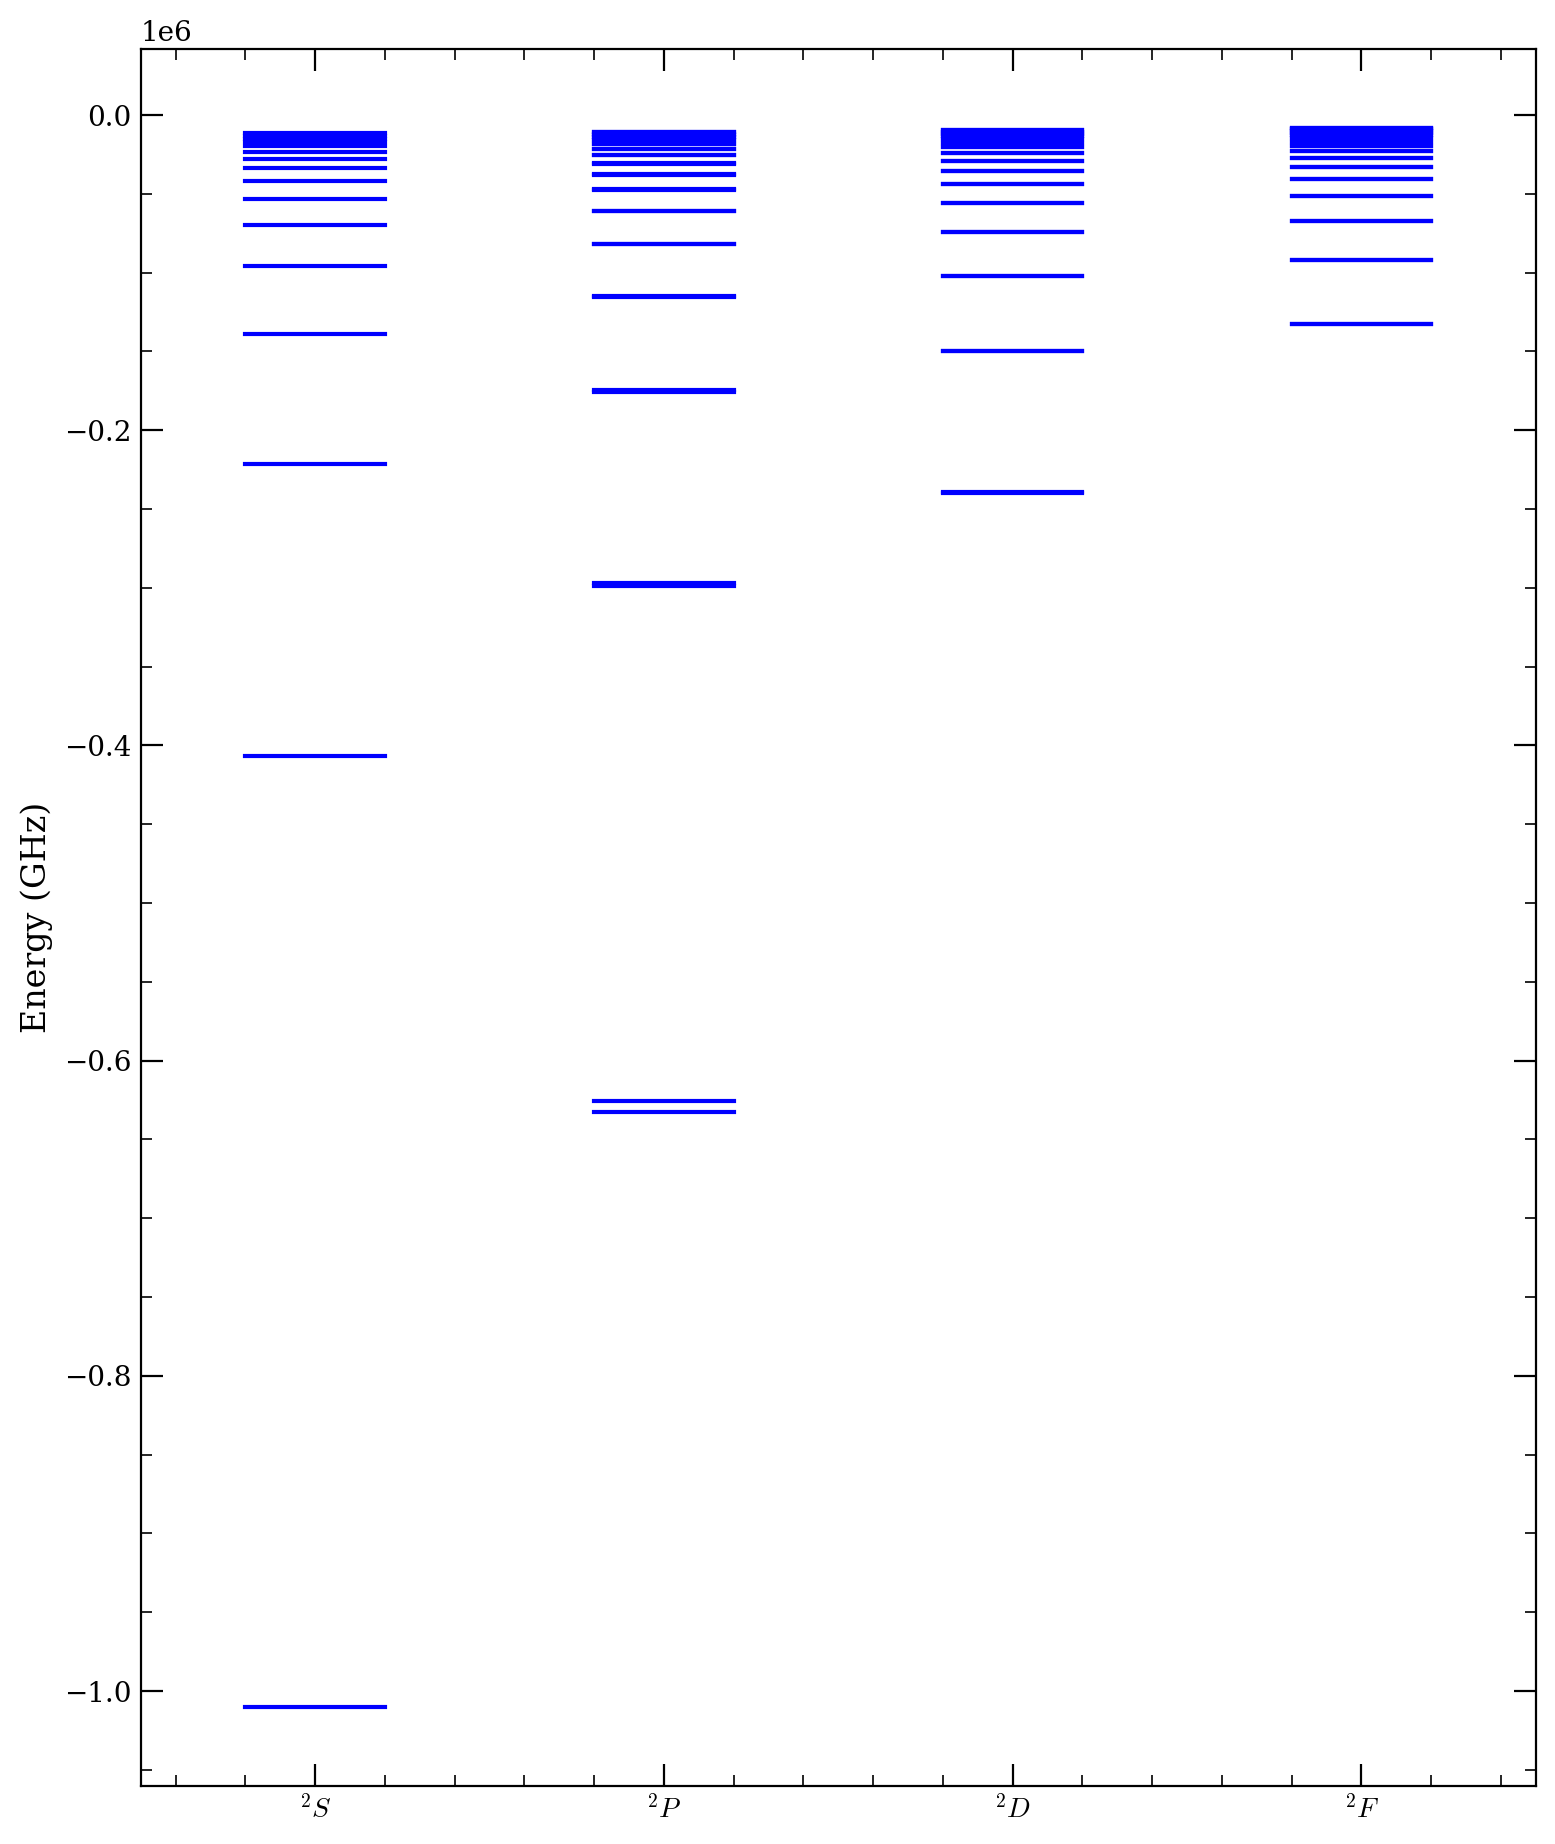

In [4]:
from arc.alkali_atom_data import Rubidium
from arc import LevelPlot

rb_atom = Rubidium()
# rb_atom.getEnergy(n=5, l=0, j=1/2)  # eV

levels = LevelPlot(rb_atom)
levels.makeLevels(5, 20, 0, 3)
levels.drawLevels('GHz')
levels.showPlot()

## Transformación Tiempo -> Corriente -> Frecuencia

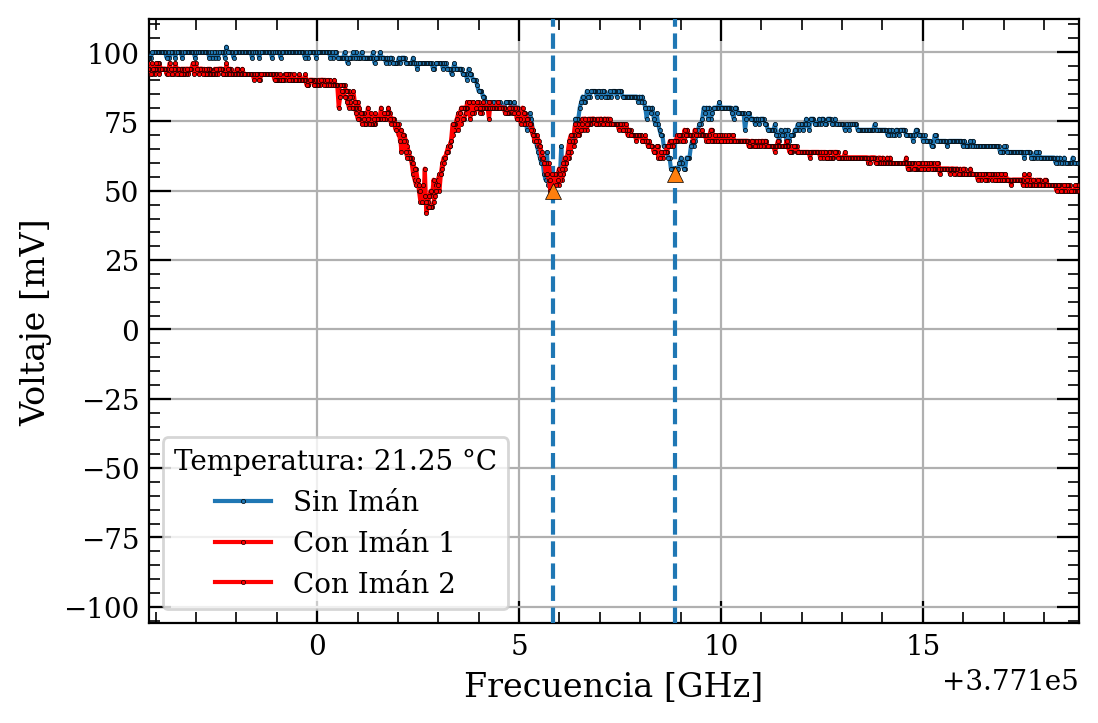

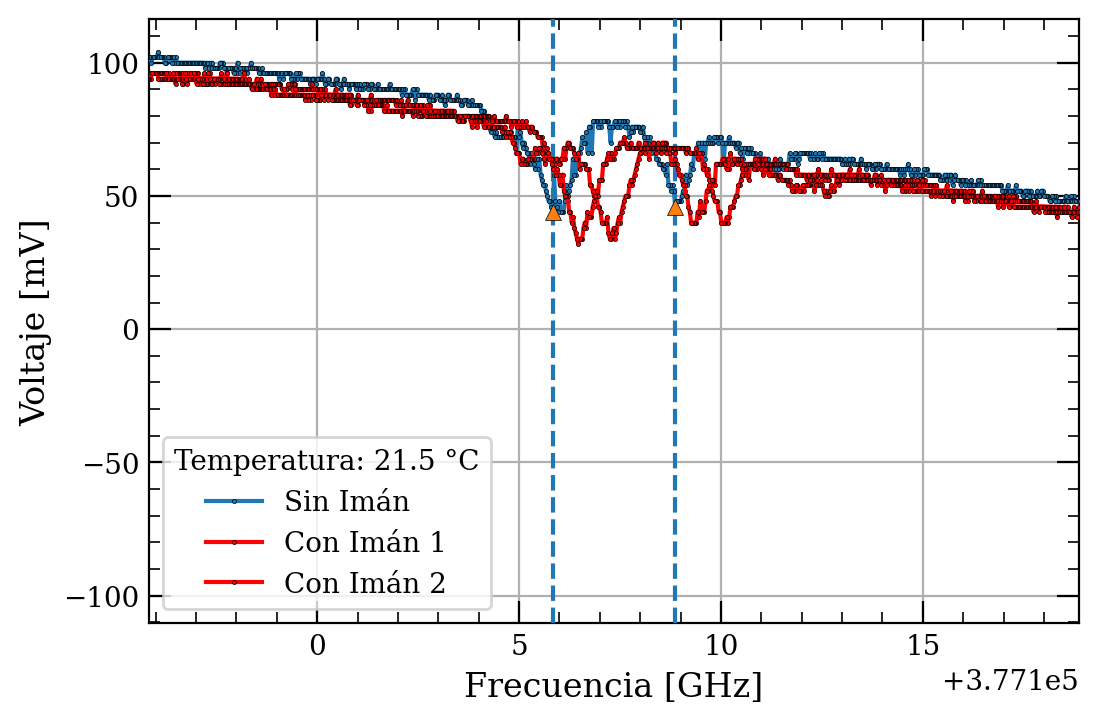

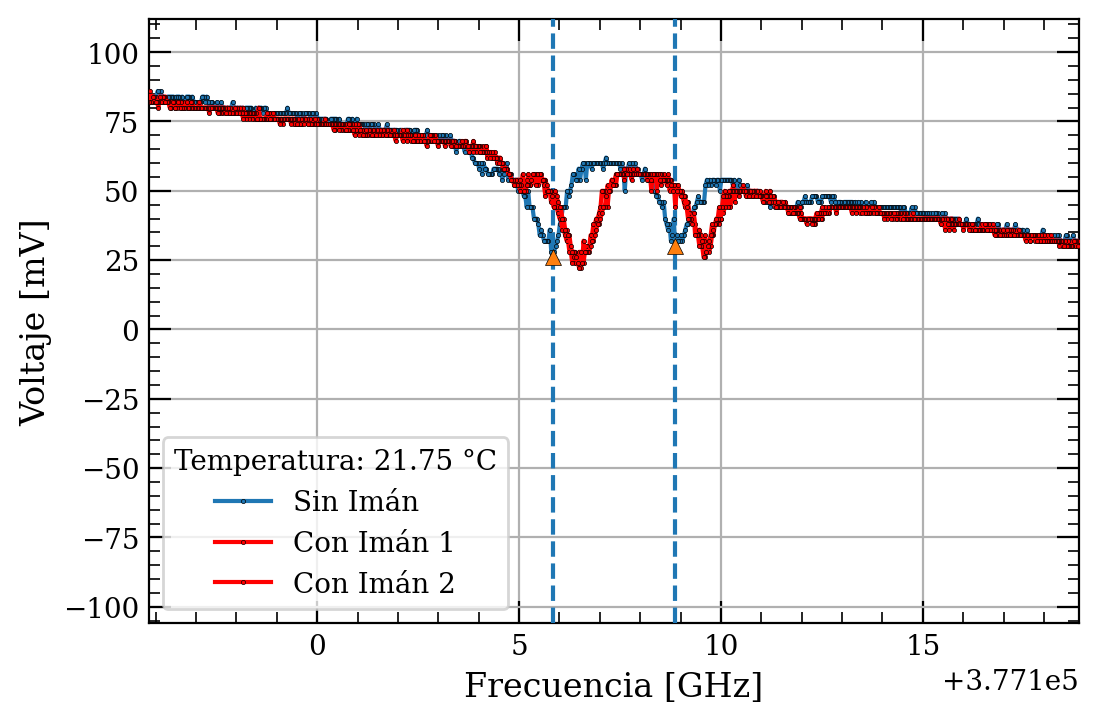

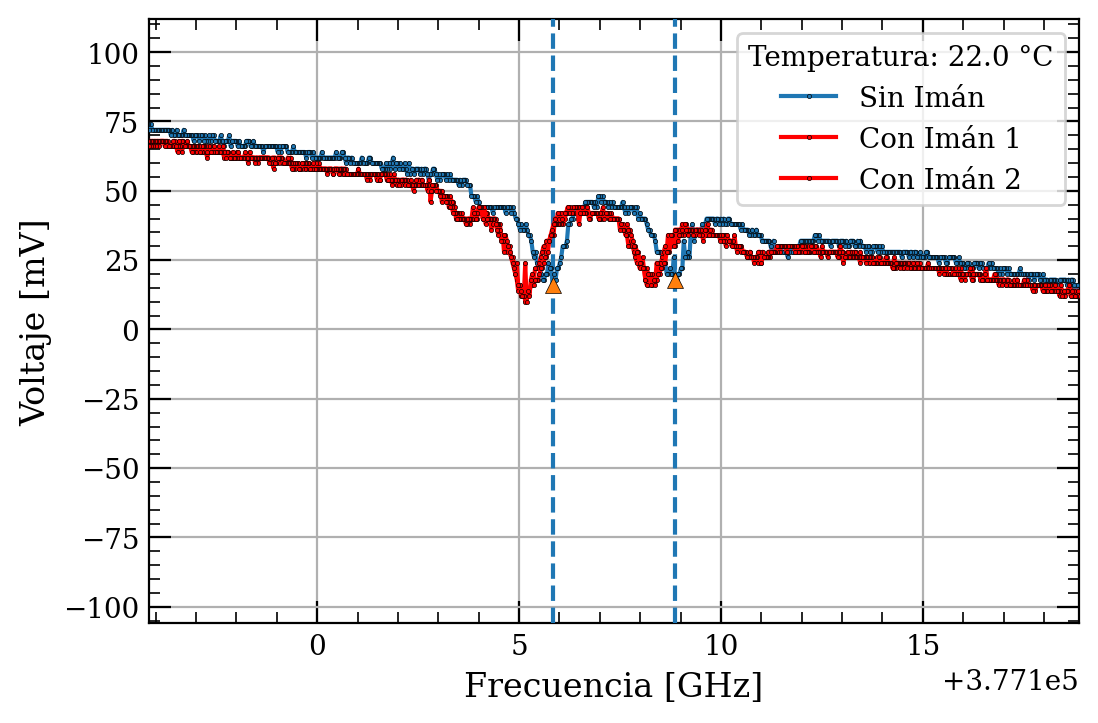

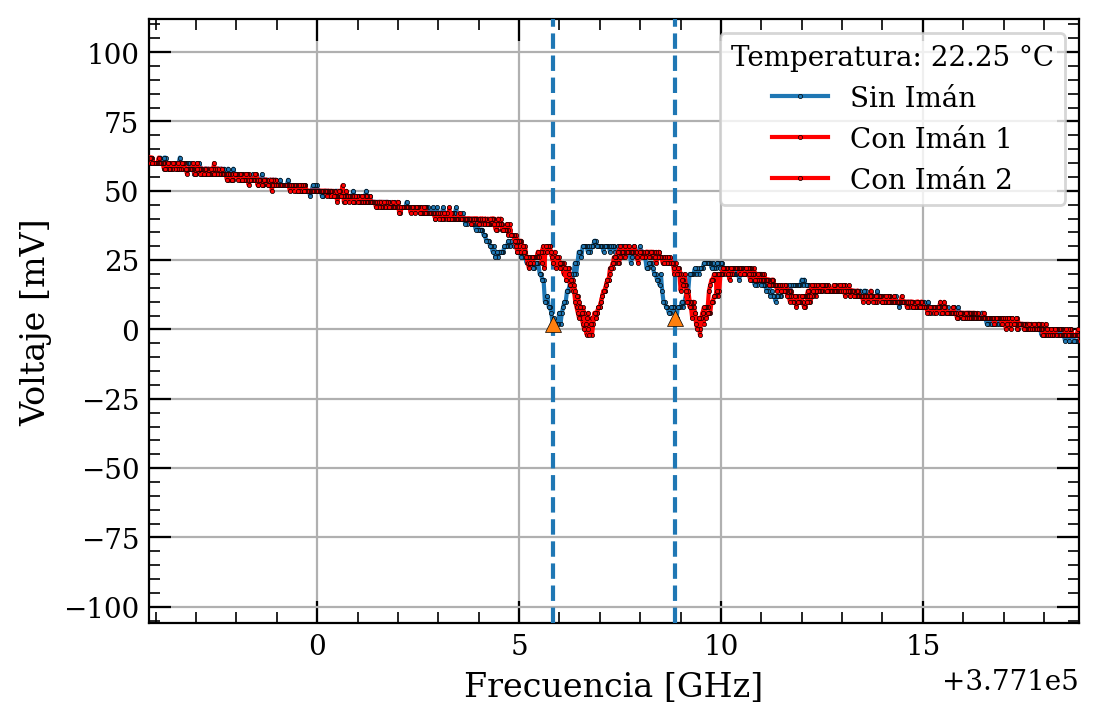

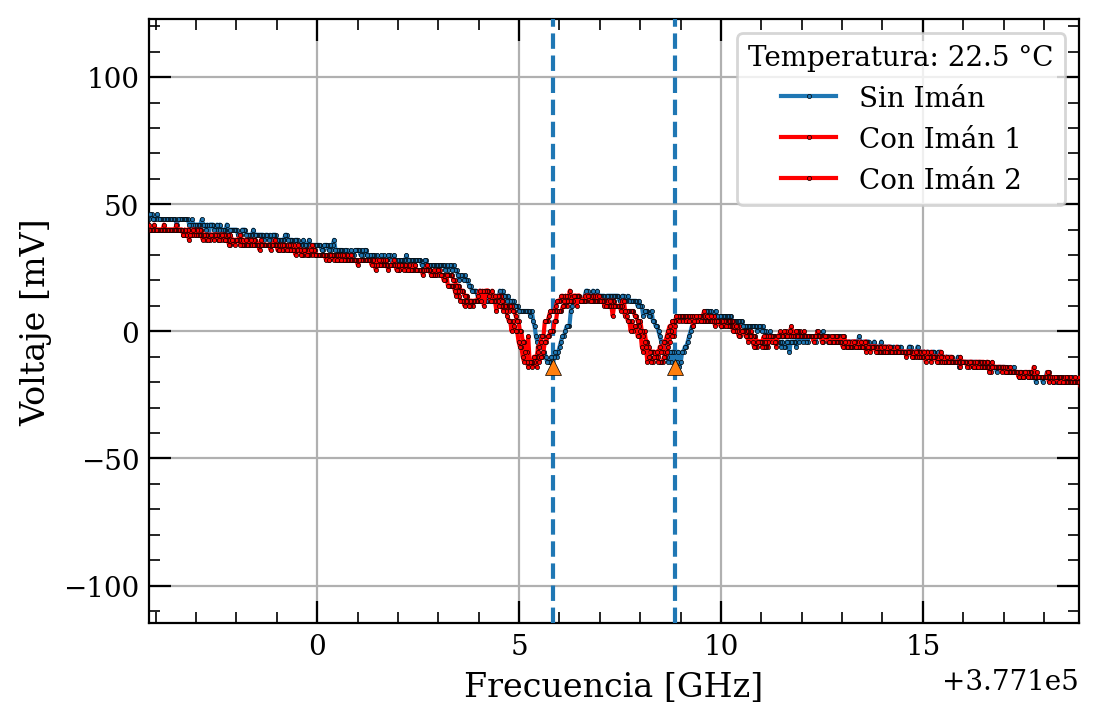

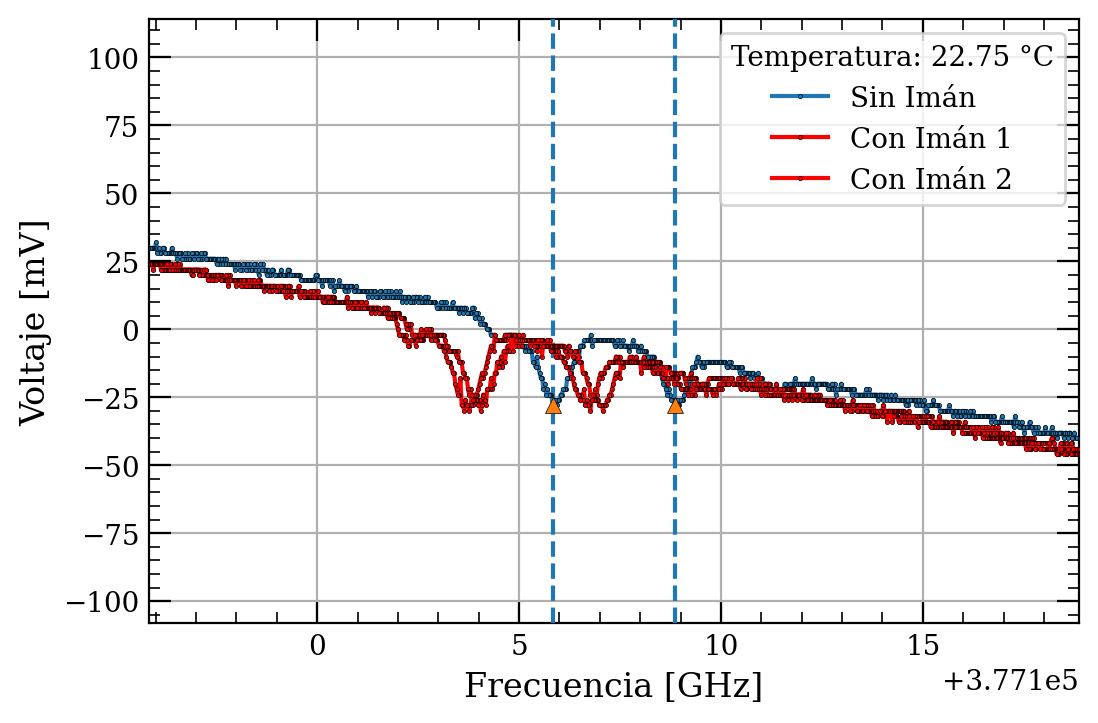

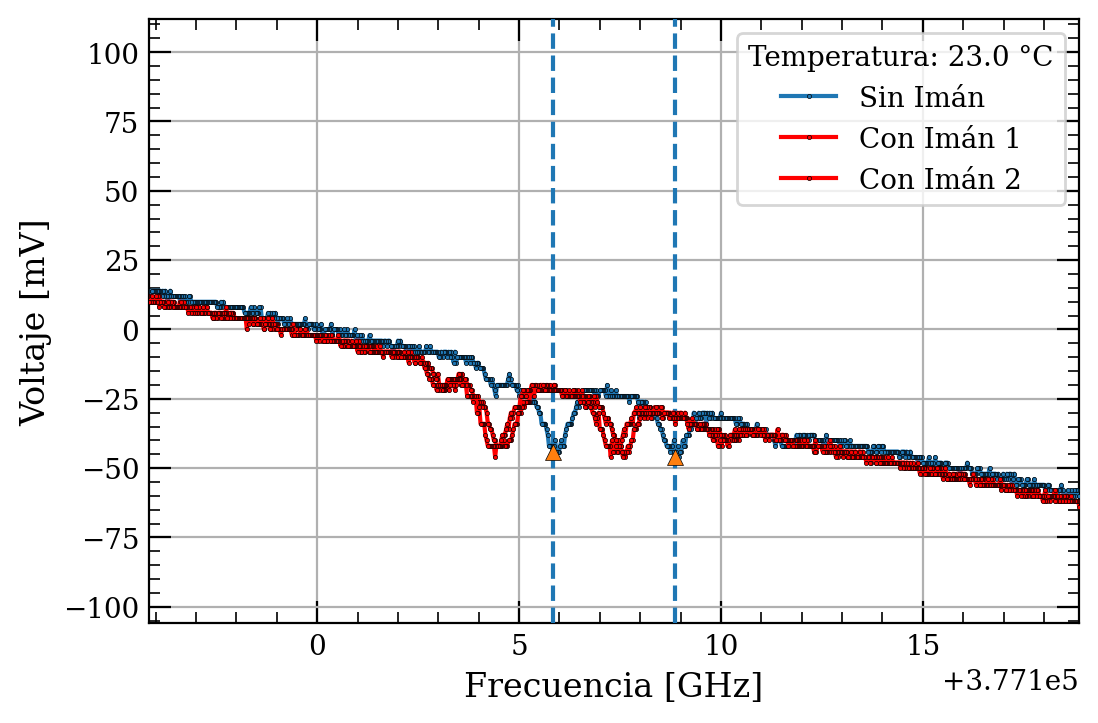

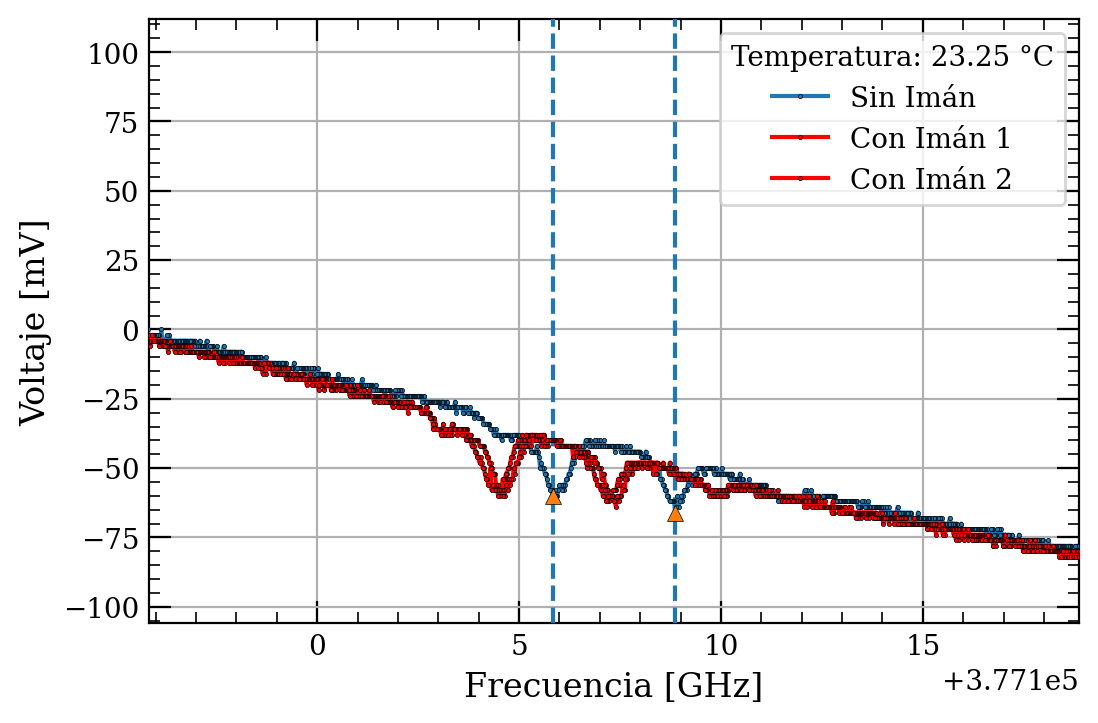

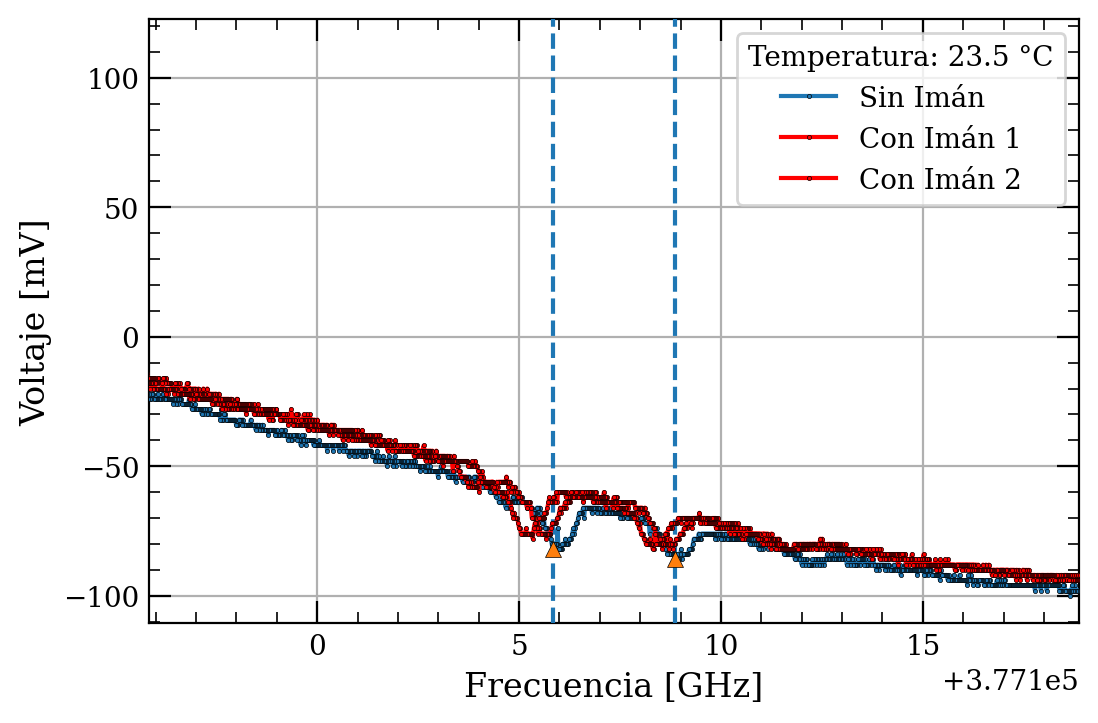

In [5]:
# %matplotlib inline
v_units = 'm'
f_units = 'G'
freqs_arr = np.zeros_like(times_arr)  # Hz
freqs_mag_arr = np.zeros_like(times_arr)  # Hz
corrientes_arr = np.zeros_like(times_arr)  # A
peaks = [0,]*times_arr.shape[0]  # Indices
# Hipotesis: los picos de tensión se asocian a los picos de corriente
corriente_setpoint = 1.4e-3  # A : Valor medio de las oscilaciones
corriente_depth = 0.1/100
corriente_max = corriente_setpoint*(1+corriente_depth)  # A
corriente_min = corriente_setpoint*(1-corriente_depth)  # A
corriente_rango = corriente_max - corriente_min  # A
for i, temp in enumerate(Temps_arr[:, 0]):
    # Para la medición sin imán:
    t_max = times_arr[i][np.argmax(V1[i])]  # s
    t_min = times_arr[i][np.argmin(V1[i])]  # s
    m = (corriente_max - corriente_min)/(t_max - t_min)  # A/s
    corrientes_arr[i] = m*(times_arr[i] - t_min) + corriente_min  # A
    popt, pcov = curve_fit(lineal, corrientes_arr[i], V1[i])
    # Para la medición con imán:
    t_mag_max = times_mag_arr[i][np.argmax(V1_mag[i])]  # s
    t_mag_min = times_mag_arr[i][np.argmin(V1_mag[i])]  # s
    m_mag = (corriente_max - corriente_min)/(t_mag_max - t_mag_min)  # A/s
    corrientes_mag = m_mag*(times_mag_arr[i] - t_mag_min) + corriente_min  # A

    peaks[i] = find_peaks(-(V1[i] - lineal(corrientes_arr[i], *popt)),
                          distance=30, prominence=0.01, height=0.015)[0]
    # Sabemos que estos corresponden com los picos que encontramos con find_peaks:
    idx1 = 6
    idx2 = 7
    freqs_arr[i] = corriente_a_frecuencia(corrientes_arr[i],
                                          freqs_rubidio[[idx1, idx2]],  # Hz
                                          corrientes_arr[i][peaks[i][[-2, -1]]])  # A
    
    freqs_mag_arr[i] = corriente_a_frecuencia(corrientes_mag,
                                              freqs_rubidio[[idx1, idx2]],  # Hz
                                              corrientes_arr[i][peaks[i][[-2, -1]]])  # A
    # Plots:
    plt.figure()
    plt.plot(SCALE[f_units]*freqs_arr[i],
             SCALE[v_units]*V1[i],
             '.-', ms=3, mec='k', mew=0.25,
             zorder=7, label="Sin Imán")
    plt.plot(SCALE[f_units]*freqs_mag_arr[i],
             SCALE[v_units]*V1_mag[i],
             'r.-', ms=3, mec='k', mew=0.25,
             zorder=8, label="Con Imán 1")
    plt.plot(SCALE[f_units]*freqs_mag_arr[i],
             SCALE[v_units]*V2_mag[i],
             'r.-', ms=3, mec='k', mew=0.25,
             zorder=8, label="Con Imán 2")
    plt.plot(SCALE[f_units]*freqs_arr[i][peaks[i]],
             SCALE[v_units]*V1[i][peaks[i]],
             '^', mec='k', mew=0.25, zorder=10)
    plt.axvline(SCALE[f_units]*freqs_arr[i][peaks[i][-1]],
                ls='--', c='C0', zorder=4)
    plt.axvline(SCALE[f_units]*freqs_arr[i][peaks[i][-2]],
                ls='--', c='C0', zorder=4)
    plt.grid(True)
    plt.legend(title=f"Temperatura: {temp} °C")
    plt.ylabel(f"Voltaje [{v_units}V]")
    plt.xlim(SCALE[f_units]*freqs_arr[i][peaks[i][-1]] -10 , SCALE[f_units]*freqs_arr[i][peaks[i][-2]]+10 )
    plt.xlabel(f"Frecuencia [{f_units}Hz]")
    plt.show()

peaks = np.array(peaks)

Señales DAVS

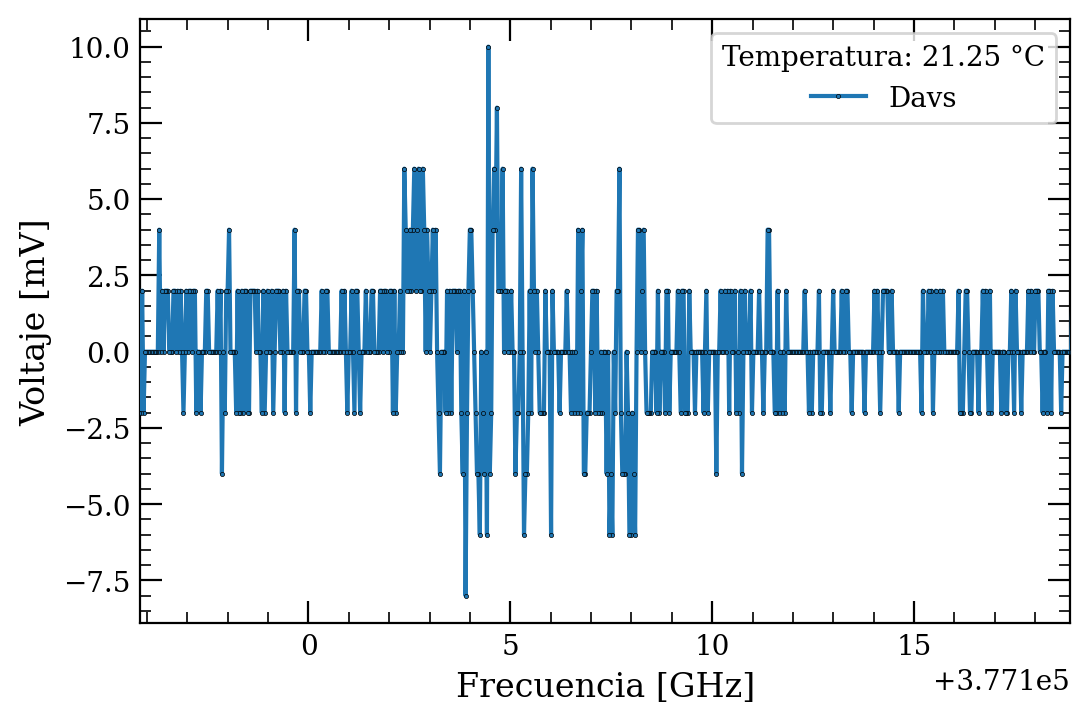

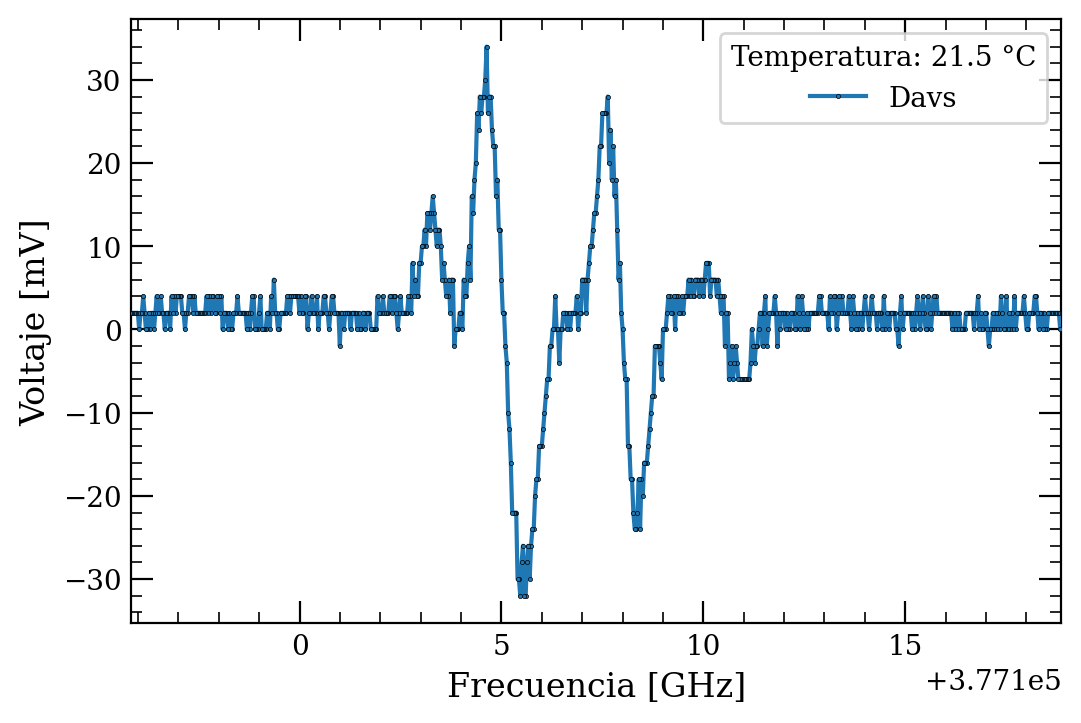

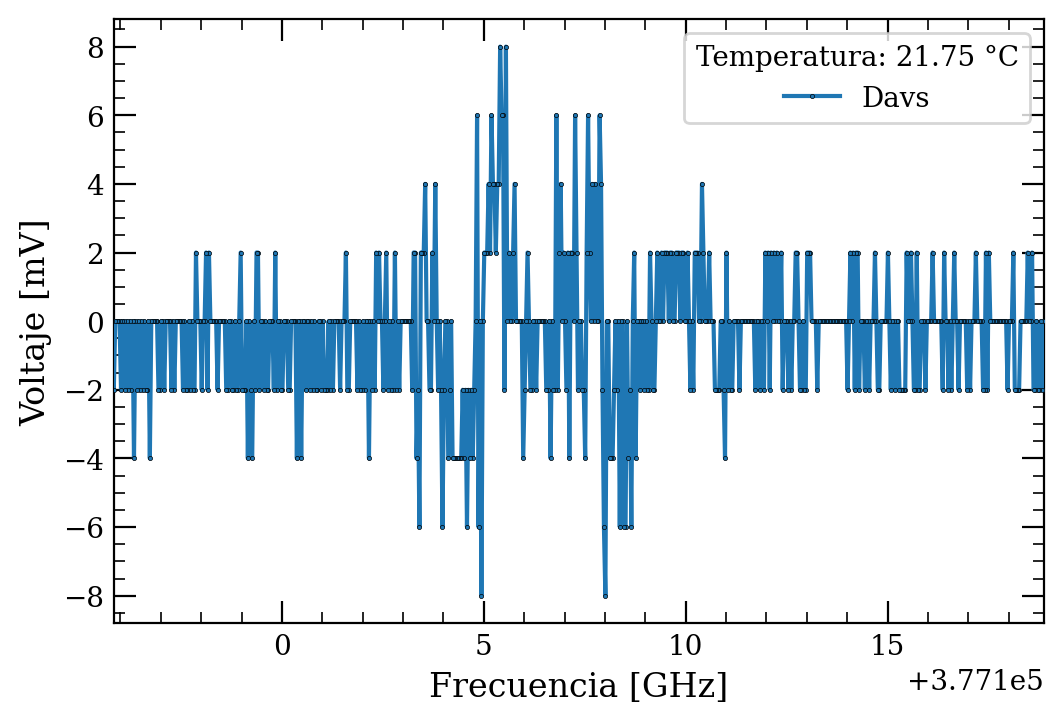

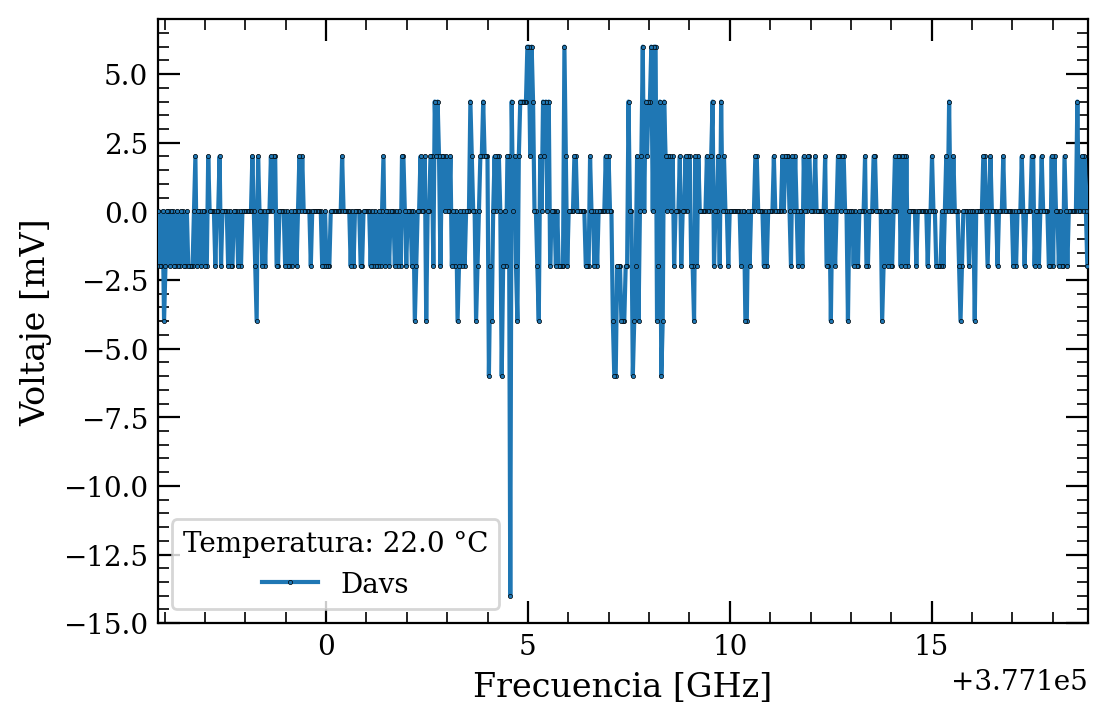

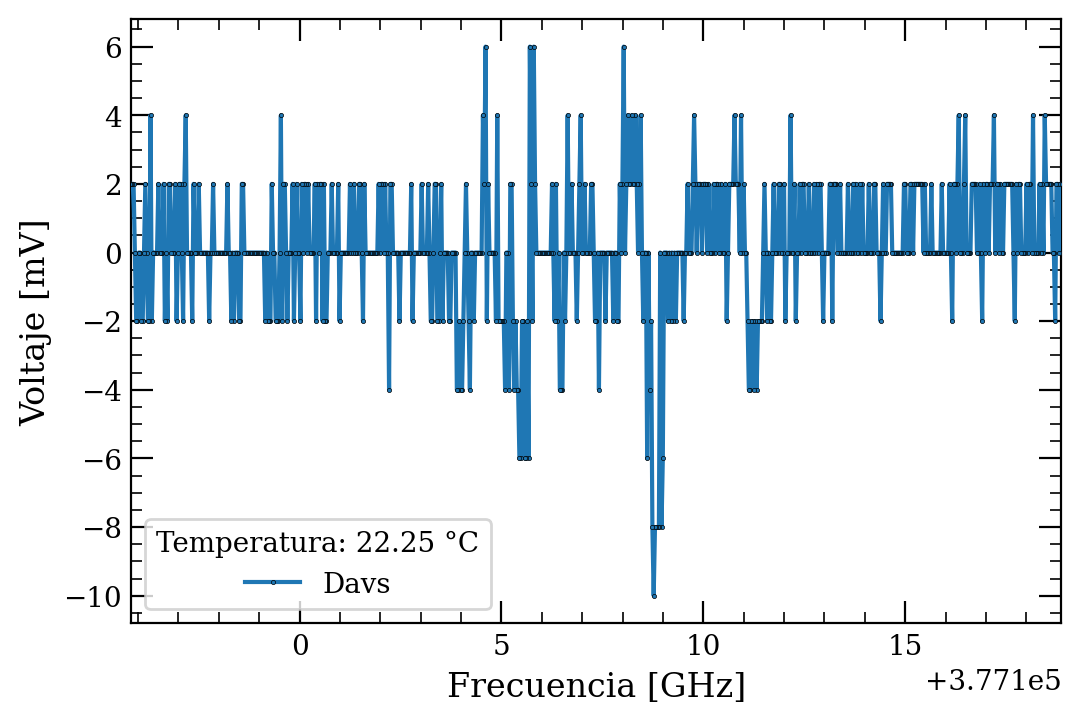

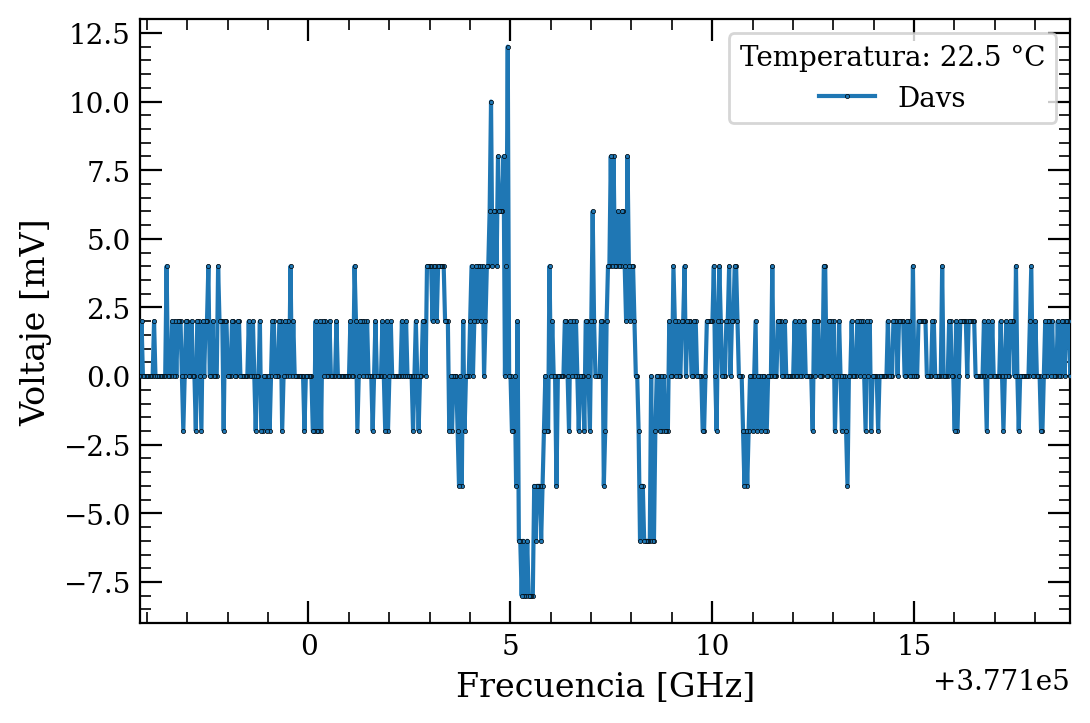

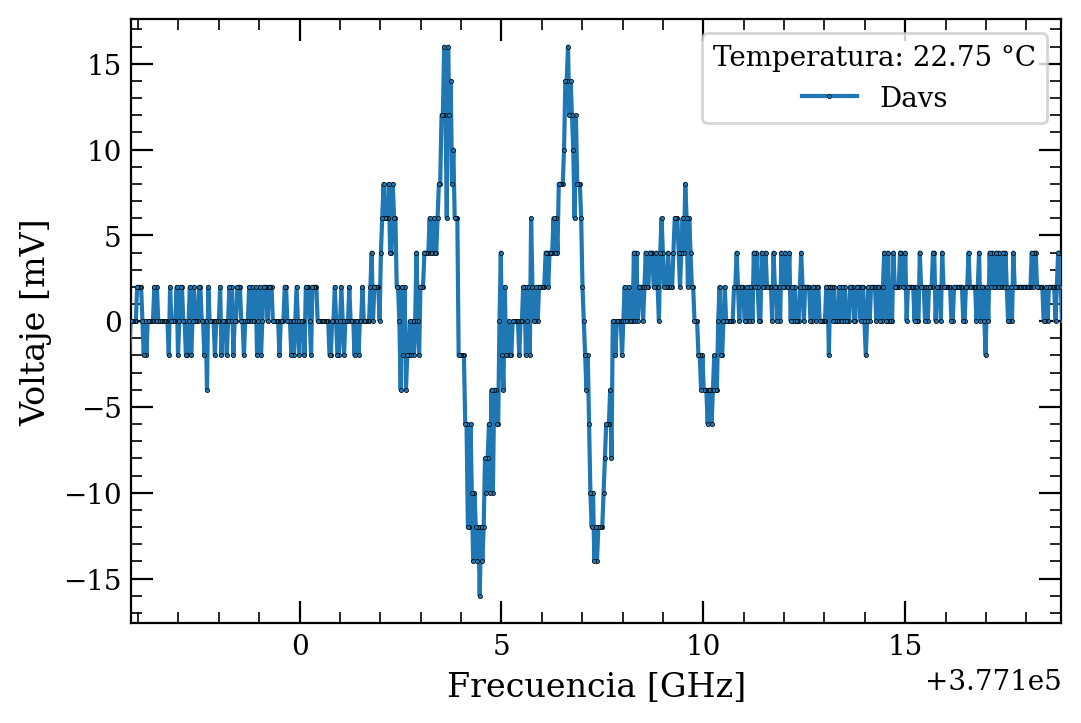

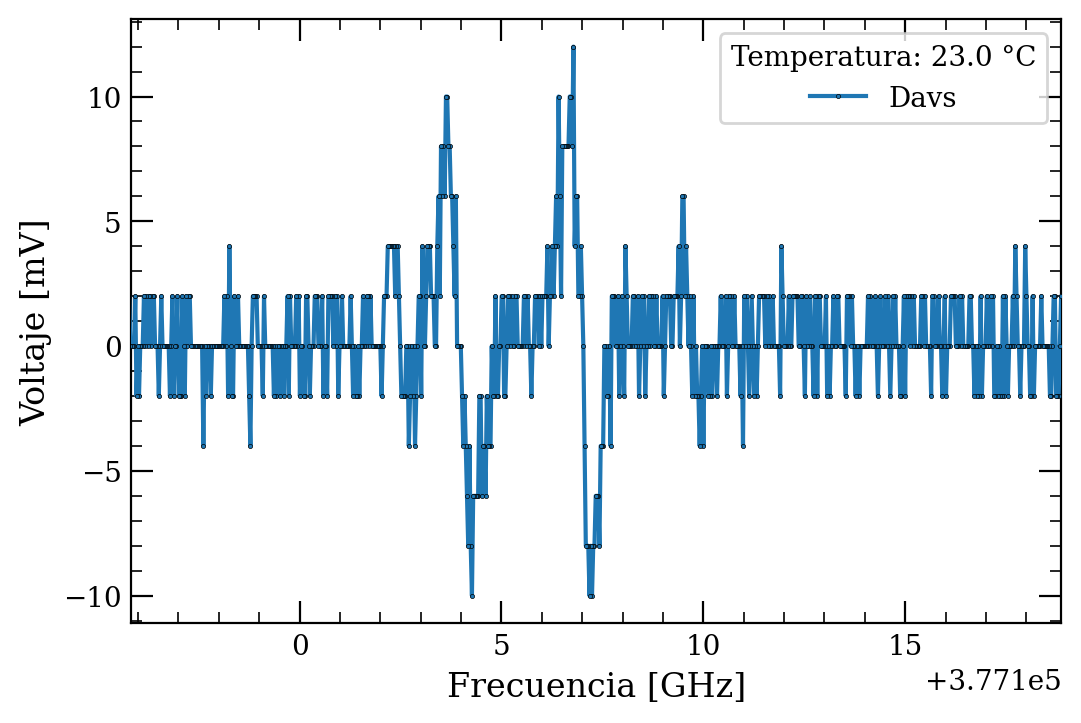

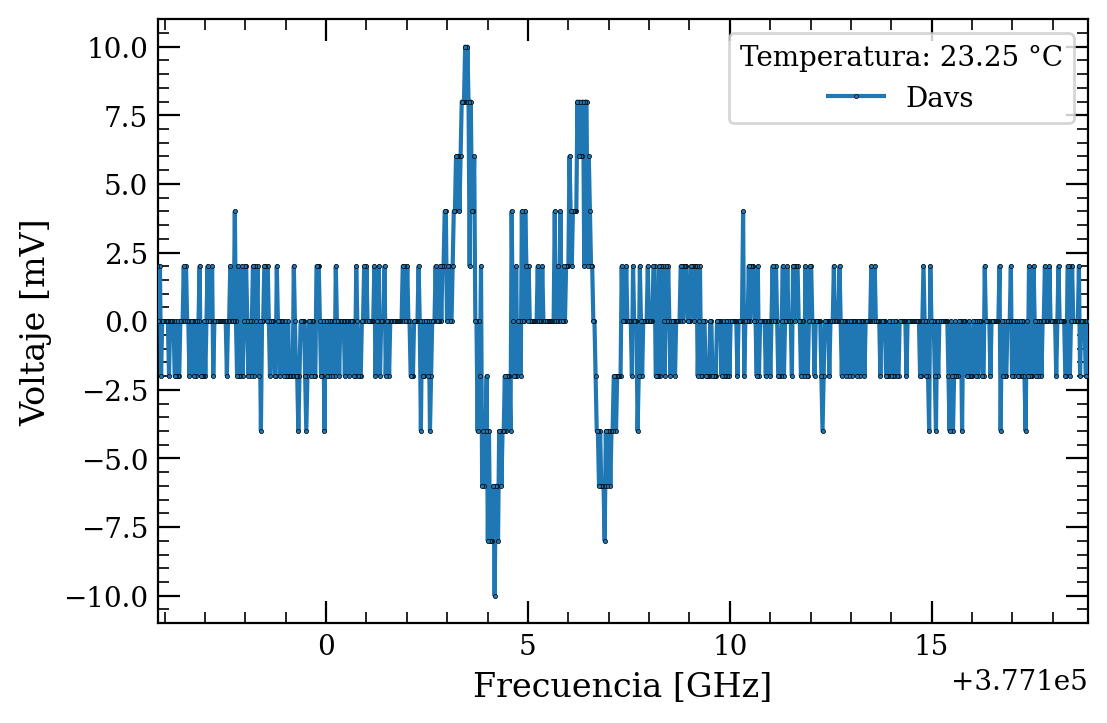

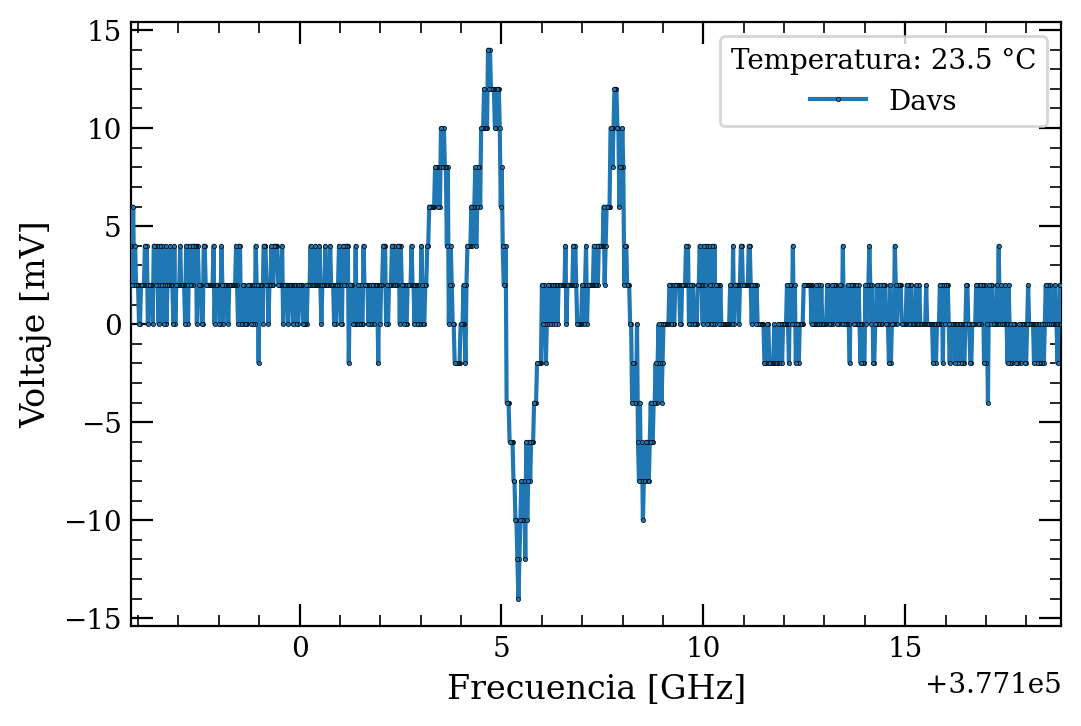

In [6]:
Davs_arr = np.zeros_like(times_arr)

for i, temp in enumerate(Temps_arr[:, 0]):
    Davs_arr[i] = V1_mag[i]-V2_mag[i]
    plt.figure()
    plt.plot(SCALE[f_units]*freqs_arr[i],
             SCALE[v_units]*Davs_arr[i],
             '.-', ms=3, mec='k', mew=0.25,
             zorder=7, label="Davs")
    plt.legend(title=f"Temperatura: {temp} °C")
    plt.ylabel(f"Voltaje [{v_units}V]")
    plt.xlim(SCALE[f_units]*freqs_arr[i][peaks[i][-1]] -10 , SCALE[f_units]*freqs_arr[i][peaks[i][-2]]+10 )
    plt.xlabel(f"Frecuencia [{f_units}Hz]")
    plt.show()

In [8]:
# DESCOMENTAR SI SE CORRE LOCALMENTE PARA VENTANA INTERACTIVA
%matplotlib qt5
norm = Normalize(Temps_arr.min(), Temps_arr.max())  # Un normalizador que asocia valores del intervalo de n al rango [0:1].
warmscale = plt.cm.ScalarMappable(norm, 'inferno', )  # Asocio los valores del rango de n normalizado en [0:1] a una paleta de colores.
colors1 = warmscale.to_rgba  # la función que dado n devuelve el color asociado
coolscale = plt.cm.ScalarMappable(norm, 'cool', )  # Asocio los valores del rango de n normalizado en [0:1] a una paleta de colores.
colors2 = coolscale.to_rgba  # la función que dado n devuelve el color asociado


v_units = 'm'
f_units = 'G'

fig = plt.figure(figsize=(8, 4), dpi=150)
ax = fig.add_subplot(projection='3d')

# Grafico de los puntos que usamos para calibrar:
plt.plot(SCALE[f_units]*freqs_rubidio[[6,]*10],
         Temps_arr[:, 0],
         SCALE[v_units]*np.diag(V1[:, peaks.T[1]]),
         'k.-', ms=3, lw=0.5)
plt.plot(SCALE[f_units]*freqs_rubidio[[7,]*10],
         Temps_arr[:, 0],
         SCALE[v_units]*np.diag(V1[:, peaks.T[0]]),
         'k.-', ms=3, lw=0.5)

# Superficie definida por las mediciones:
# ax.plot_surface(SCALE[f_units]*freqs_arr,
#                 Temps_arr,
#                 SCALE[v_units]*V1,
#                 color='C1', alpha=0.25)

# Curvas medidas sin imán:
for f, t, v in zip(SCALE[f_units]*freqs_arr[::-1],
                   Temps_arr[::-1],
                   SCALE[v_units]*V1[::-1]):
    ax.plot(f, t, v, c=colors1(t[0]), lw=0.5)

# Curvas medidas con imán:
for f, t, v in zip(SCALE[f_units]*freqs_mag_arr[::-1],
                   Temps_arr[::-1],
                   SCALE[v_units]*V1_mag[::-1]):
    ax.plot(f, t, v, c=colors2(t[0]), ls='--', lw=0.5, alpha=0.5)

ax.set_xlabel(f"Frecuencia [{f_units}Hz]")
ax.set_ylabel("Temperaturas [°C]")
ax.set_zlabel(f"Volataje [{v_units}V]")
plt.show()

# %matplotlib inline

virtual void QEventDispatcherUNIX::registerSocketNotifier(QSocketNotifier*): Multiple socket notifiers for same socket 11 and type Read


In [9]:
# DESCOMENTAR SI SE CORRE LOCALMENTE PARA VENTANA INTERACTIVA
%matplotlib qt5
norm = Normalize(V1.min(), V1.max())  # Un normalizador que asocia valores del intervalo de n al rango [0:1].
voltscale = plt.cm.ScalarMappable(norm, 'viridis', )  # Asocio los valores del rango de n normalizado en [0:1] a una paleta de colores.
colorsV = voltscale.to_rgba  # la función que dado n devuelve el color asociado



i_units = 'm'
f_units = 'G'

fig = plt.figure(figsize=(8, 4), dpi=150)
ax = fig.add_subplot(projection='3d')

plt.plot(SCALE[i_units]*np.diag(corrientes_arr[:, peaks.T[1]]),
         Temps_arr[:, 0],
         SCALE[f_units]*freqs_rubidio[[6,]*10],
         'k.-', ms=3, lw=0.5)
plt.plot(SCALE[i_units]*np.diag(corrientes_arr[:, peaks.T[0]]),
         Temps_arr[:, 0],
         SCALE[f_units]*freqs_rubidio[[7,]*10],
         'k.-', ms=3, lw=0.5)

# Superficie definida por las mediciones:
# ax.plot_surface(SCALE[i_units]*corrientes_arr,
#                 Temps_arr,
#                 SCALE[f_units]*freqs_arr,
#                 color='C1', alpha=0.25, zorder=3)

# Curvas medidas sin imán:
for i, t, f, v in zip(SCALE[i_units]*corrientes_arr[::-1],
                      Temps_arr[::-1],
                      SCALE[f_units]*freqs_arr[::-1],
                      V1[::-1]):
    ax.scatter3D(i[::25], t[::25], f[::25], c=colorsV(v[::25]), s=5, lw=0.5, zorder=5,
                 )

ax.set_xlabel(f"Corriente [{i_units}A]")
ax.set_zlabel(f"Frecuencia [{f_units}Hz]")
ax.set_ylabel("Temperaturas [°C]")
plt.show()

virtual void QEventDispatcherUNIX::registerSocketNotifier(QSocketNotifier*): Multiple socket notifiers for same socket 11 and type Read


In [5]:
np.loadtxt("pitaya0.csv", delimiter=',', skiprows=1, unpack=True)

array([[-6.398, -6.373, -6.349, ..., 18.694, 18.719, 18.743],
       [ 0.1  ,  0.1  ,  0.102, ...,  0.144,  0.145,  0.146],
       [-6.398, -6.373, -6.349, ..., 18.694, 18.719, 18.743],
       [ 0.103,  0.103,  0.106, ...,  0.146,  0.147,  0.148]])